## In this project we investigate the several variants of RNN with a novel architecture where we jointly train an autoencoder and a classifier attached on its latent space. 

In [1]:
import nltk
import sklearn
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import pydot
from lxml import html, etree
from keras.layers import Lambda
from keras import backend as K
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, cohen_kappa_score
#nltk.download()
# Download Corpora -> stopwords, Models -> punkt
from keras import losses
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html, etree
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier

import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html, etree
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import GRU, RNN, LSTM, Dense, Activation, Embedding, Dropout, Input, RepeatVector, TimeDistributed, Bidirectional
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint





Using TensorFlow backend.


In [7]:
#Parsing the reu data:
def parse_reu(reu):
    """Parses the etree object and returns a list of dictionary of reuters attr
    Output: {'topics': the topic of the article, 'places': where it is located, 
        'split': training/test split, 'body':the text of the article as a set of words with stopwords removed}
    """
    root= reu.getroot()
    articles = root.body.getchildren()
    stop_words = set(stopwords.words('english'))
    reu_pl = []
    for a in articles:
        reu_parse = {}
        if a.attrib['topics'] != 'YES':
            next
        topics = a.find('topics').findall('d')
        if topics:
            reu_parse['topics'] = [t.text for t in topics]
        else:
            reu_parse['topics'] = []
        places = a.find('places').findall('d')
        if places:
            reu_parse['places'] = [t.text for t in places]
        reu_parse['split'] = a.attrib['lewissplit']
        rtxt = a.find('text')
        word_tokens = word_tokenize(rtxt.text_content())
        filtered_sentence = set([w.lower() for w in word_tokens if not w in stop_words])
        reu_parse['body'] = filtered_sentence
        reu_pl.append(reu_parse)
    return reu_pl
##################

In [8]:
#Define the maximum word size as 2000.
whole_reu = []
filename = []
for index in range(10):
    filename = 'reuters/reut2-00'+np.str(index)+'.sgm'
    current_reu = html.parse(filename)
    reu_current = parse_reu(current_reu)
    whole_reu += reu_current
for index in range(10,22):
    filename = 'reuters/reut2-0'+np.str(index)+'.sgm'
    current_reu = html.parse(filename)
    reu_current = parse_reu(current_reu)
    whole_reu += reu_current  

In [9]:
#Construct the vectorizer to transform the text data note that here we didn't use maximal features
MAX_VOC = 2000
max_length = 300
vectorizer = Tokenizer(num_words = MAX_VOC)
whole_article = [" ".join(tt.lower() for tt in ss['body']) for ss in whole_reu]
vectorizer.fit_on_texts(whole_article)
sequences = vectorizer.texts_to_sequences(whole_article)
word_index = vectorizer.word_index
X_matrix = pad_sequences(sequences, maxlen = max_length)


In [10]:
#Transform to the embedding matrix:
X_matrix.shape

(21578, 300)

In [11]:
#Creating the multinomial response:
Y_earn = np.asarray([np.int(ss['topics'] == ['earn']) for ss in whole_reu])
Y_acq = np.asarray([np.int(ss['topics'] == ['acq']) for ss in whole_reu])

In [12]:
#Extract the embedding matrix:
"""
:Reference: https://www.kaggle.com/jannesklaas/19-lstm-for-email-classification
"""
import os
embedding_dim = 300

embeddings_index = {} # We create a dictionary of word -> embedding
f = open('glove.42B.300d.txt') # Open file

# In the dataset, each line represents a new word embedding
# The line starts with the word and the embedding values follow
for line in f:
    values = line.split()
    word = values[0] # The first value is the word, the rest are the values of the embedding
    embedding = np.asarray(values[1:], dtype='float32') # Load embedding
    embeddings_index[word] = embedding # Add embedding to our embedding dictionary
f.close()

print('Found %s word vectors.' % len(embeddings_index))
word_index = vectorizer.word_index
nb_words = min(MAX_VOC, len(word_index)) # How many words are there actually

# Create a random matrix with the same mean and std as the embeddings
embedding_matrix = np.random.normal(0, 1, (nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= MAX_VOC: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

Found 1917494 word vectors.


In [13]:
# Create a random matrix with the same mean and std as the embeddings
embedding_matrix = np.random.normal(0, 1, (nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= MAX_VOC: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

#EDA has been done in homework so I would skip it.

In [14]:
#Apply the simple LSTM to classify:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Activation, Embedding, Dropout
from sklearn.model_selection import train_test_split, KFold

kf = KFold(n_splits=5, random_state = 42)
X_train_e, X_test_e, Y_train_e, Y_test_e = train_test_split(X_matrix, Y_earn, test_size = 0.2, random_state = 42)
X_train_a, X_test_a, Y_train_a, Y_test_a = train_test_split(X_matrix, Y_acq, test_size = 0.2, random_state = 1)
n = X_matrix.shape[0]
n_t = X_train_e.shape[0]
n_v = X_test_e.shape[0]

def LSTM_simple():
    model_ls1 = Sequential()
    model_ls1.add(Embedding(MAX_VOC, embedding_dim, input_length = max_length,
                           weights = [embedding_matrix],
                           trainable = False))
    model_ls1.add(LSTM(64))
    model_ls1.add(Dense(1, activation = 'sigmoid'))
    model_ls1.add(Dropout(0.2))
    OPTIM = Adam(lr=0.004)
    model_ls1.compile(loss = 'binary_crossentropy',
                 optimizer = OPTIM, metrics = ['accuracy'])
    model_ls1.summary()
    return model_ls1
    

In [25]:
#Try the ordinary RNN without LSTM version:
def GRU_simple():
    model_1 = Sequential()
    model_1.add(Embedding(MAX_VOC, embedding_dim, input_length = max_length,
                         weights = [embedding_matrix],
                         trainable = False))
    model_1.add(GRU(64))
    model_1.add(Dense(1, activation = 'sigmoid'))
    model_1.add(Dropout(0.2))
    OPTIM = Adam(lr = 0.001)
    model_1.compile(loss = 'binary_crossentropy',
                   optimizer = OPTIM, metrics = ['accuracy'])
    return model_1

In [26]:
########
callbacks = [EarlyStopping(monitor='val_acc', patience=3),
             ModelCheckpoint(filepath='best_model_simple_RNN_earn.h5', monitor = 'val_acc')]
es = callbacks
score_earn0 = []
acc_earn0 = []
cv_pred_0e = np.zeros([n_t])
score_pred_0e = np.zeros([n_t])
test_pred_0e = np.zeros([n_v])
ind = 0
model = GRU_simple()
model.fit(X_train_e, Y_train_e, batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
pred_test = model.predict(X_test_e)
test_pred_0e = pred_test.reshape(-1)
#cv_pred_1e[test_index] = pred_c
#score_earn1.append(score)
#acc_earn1.append(acc)
ind += 1

Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 32s 2ms/step - loss: 0.7931 - acc: 0.8815 - val_loss: 0.1942 - val_acc: 0.9343
Epoch 2/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.7045 - acc: 0.9174 - val_loss: 0.1506 - val_acc: 0.9302
Epoch 3/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.7390 - acc: 0.9221 - val_loss: 0.1518 - val_acc: 0.9424
Epoch 4/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.6547 - acc: 0.9308 - val_loss: 0.1124 - val_acc: 0.9571
Epoch 5/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.7022 - acc: 0.9311 - val_loss: 0.1113 - val_acc: 0.9606
Epoch 6/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.6849 - acc: 0.9156 - val_loss: 0.1182 - val_acc: 0.9542
Epoch 7/80
13809/13809 [==============================] - 30s 2ms/step - loss: 0.7044 - acc: 0.9333 - val_loss: 0.0998 - val_acc:

In [27]:
########
callbacks = [EarlyStopping(monitor='val_acc', patience=3),
             ModelCheckpoint(filepath='best_model_simple_RNN_acq.h5', monitor = 'val_acc')]
es = callbacks
score_earn0 = []
acc_earn0 = []
cv_pred_0a = np.zeros([n_t])
score_pred_0a = np.zeros([n_t])
test_pred_0a = np.zeros([n_v])
ind = 0
model = GRU_simple()
model.fit(X_train_a, Y_train_a, batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
pred_test = model.predict(X_test_a)
test_pred_0a = pred_test.reshape(-1)
#cv_pred_1e[test_index] = pred_c
#score_earn1.append(score)
#acc_earn1.append(acc)
ind += 1

Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.5819 - acc: 0.8919 - val_loss: 0.2210 - val_acc: 0.9073
Epoch 2/80
13809/13809 [==============================] - 30s 2ms/step - loss: 0.5096 - acc: 0.9235 - val_loss: 0.1385 - val_acc: 0.9403
Epoch 3/80
13809/13809 [==============================] - 30s 2ms/step - loss: 0.4367 - acc: 0.9410 - val_loss: 0.1134 - val_acc: 0.9534
Epoch 4/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.4404 - acc: 0.9448 - val_loss: 0.1247 - val_acc: 0.9432
Epoch 5/80
13809/13809 [==============================] - 32s 2ms/step - loss: 0.4511 - acc: 0.9480 - val_loss: 0.1082 - val_acc: 0.9589
Epoch 6/80
13809/13809 [==============================] - 31s 2ms/step - loss: 0.4399 - acc: 0.9500 - val_loss: 0.1107 - val_acc: 0.9545
Epoch 7/80
13809/13809 [==============================] - 33s 2ms/step - loss: 0.4250 - acc: 0.9545 - val_loss: 0.1108 - val_acc:

In [42]:
##
callbacks = [EarlyStopping(monitor='val_acc', patience=3),
             ModelCheckpoint(filepath='best_model_simple_LSTM_earn.h5', monitor = 'val_acc')]
es = callbacks
score_earn1 = []
acc_earn1 = []
cv_pred_1e = np.zeros([n_t])
score_pred_1e = np.zeros([n_t])
test_pred_1e = np.zeros([n_v])
ind = 0
model = LSTM_simple()
model.fit(X_train_e, Y_train_e, batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
pred_test = model.predict(X_test_e)
test_pred_1e = pred_test.reshape(-1)
#cv_pred_1e[test_index] = pred_c
#score_earn1.append(score)
#acc_earn1.append(acc)
ind += 1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 300, 300)          600000    
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
_________________________________________________________________
dropout_23 (Dropout)         (None, 1)                 0         
Total params: 693,505
Trainable params: 93,505
Non-trainable params: 600,000
_________________________________________________________________
Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 56s 4ms/step - loss: 0.7812 - acc: 0.8993 - val_loss: 0.1507 - val_acc: 0.9438
Epoch 2/80
13809/13809 [==============================] - 48s 3ms/step - loss

In [43]:
#LSTM1 for the acq:
callbacks = [EarlyStopping(monitor='val_acc', patience=3),
             ModelCheckpoint(filepath='best_model_simple_LSTM_acq.h5', monitor = 'val_acc')]

score_acq1 = []
acc_acq1 = []
cv_pred_1a = np.zeros([n_t])
score_pred_1a = np.zeros([n_t])
test_pred_1a = np.zeros([n_v])
ind = 0
model = LSTM_simple()
model.fit(X_train_a, Y_train_a, batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
pred_test = model.predict(X_test_a)
test_pred_1a = pred_test.reshape(-1)
#cv_pred_1e[test_index] = pred_c
#score_earn1.append(score)
#acc_earn1.append(acc)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 300, 300)          600000    
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
_________________________________________________________________
dropout_24 (Dropout)         (None, 1)                 0         
Total params: 693,505
Trainable params: 93,505
Non-trainable params: 600,000
_________________________________________________________________
Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 52s 4ms/step - loss: 0.5375 - acc: 0.9048 - val_loss: 0.1316 - val_acc: 0.9461
Epoch 2/80
13809/13809 [==============================] - 43s 3ms/step - loss

In [44]:
#Bidirectional LSTM classification:
def LSTM_simple_bi():
    model_ls1 = Sequential()
    model_ls1.add(Embedding(2000, output_dim = 64))
    model_ls1.add(Bidirectional(LSTM(48, return_sequences = True)))
    model_ls1.add(Bidirectional(LSTM(48)))
    model_ls1.add(Dense(1, activation = 'sigmoid'))
    OPTIM = Adam(lr=0.001)
    model_ls1.compile(loss = 'binary_crossentropy',
                 optimizer = OPTIM, metrics = ['accuracy'])
    model_ls1.summary()
    return model_ls1

In [45]:
#Acq fitting:
##
callbacks = [EarlyStopping(monitor='val_acc', patience=3),
             ModelCheckpoint(filepath='best_model_bidirec_LSTM_acq.h5', monitor = 'val_acc')]
es = callbacks
score_earn2 = []
acc_earn2 = []
cv_pred_2a = np.zeros([n_t])
score_pred_2a = np.zeros([n_t])
test_pred_2a = np.zeros([n_v])

model = LSTM_simple_bi()
model.fit(X_train_a, Y_train_a, batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
pred_test = model.predict(X_test_a)
test_pred_2a = pred_test.reshape(-1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 64)          128000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 96)          43392     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 96)                55680     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 97        
Total params: 227,169
Trainable params: 227,169
Non-trainable params: 0
_________________________________________________________________
Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 111s 8ms/step - loss: 0.2664 - acc: 0.9124 - val_loss: 0.1313 - val_acc: 0.9519
Epoch 2/80
13809/13809 [==============================] - 104s 8ms/step - loss: 0

In [54]:
##
##
callbacks = [EarlyStopping(monitor='val_acc', patience=3),
             ModelCheckpoint(filepath='best_model_bidirec_LSTM_earn.h5', monitor = 'val_acc')]
es = callbacks
score_earn2 = []
acc_earn2 = []
cv_pred_2e = np.zeros([n_t])
score_pred_2e = np.zeros([n_t])
test_pred_2e = np.zeros([n_v])

model = LSTM_simple_bi()
model.fit(X_train_e, Y_train_e, batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
pred_test = model.predict(X_test_e)
test_pred_2e = pred_test.reshape(-1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, None, 64)          128000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 96)          43392     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 96)                55680     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 97        
Total params: 227,169
Trainable params: 227,169
Non-trainable params: 0
_________________________________________________________________
Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 85s 6ms/step - loss: 0.2605 - acc: 0.8992 - val_loss: 0.1161 - val_acc: 0.9597
Epoch 2/80
13809/13809 [==============================] - 83s 6ms/step - loss: 0.0

In [55]:
def LSTM_AE_clf_binary(n_feature,
                inter_dim1, 
                latent_dim, 
                vocab_size, 
                embedding_dim, 
                max_length, 
                embedding_matrix):

	"""
	:Construct a variational autoencoder with LSTM as component.
	Param:
	input_dim1:
	input_dim2:
	inter_dim1: Intermediate dimension for hidden layer
	latent_dim: 
	"""
	OPTIM = Adam(lr = 0.002)

	#Embedding: Start from the word count frequency matrix and first we get the word embedding from a previous text database:
	X_input = Input(shape = (n_feature, ))
	X = Embedding(vocab_size, embedding_dim, input_length = max_length,
		weights = [embedding_matrix], trainable = False)(X_input)

	#Encoder:
	ENC = LSTM(inter_dim1, return_sequences = True)(X)

	latent = LSTM(latent_dim)(ENC)

	#Decoder:
	DEC = RepeatVector(embedding_dim)(latent)
	DEC = LSTM(inter_dim1, return_sequences = True)(DEC)
	DEC = LSTM(inter_dim1)(DEC)
	output = Dense(embedding_dim, activation = 'softmax', name = 'AE')(DEC)


	#Attach a classifier:
	h1 = Dense(np.int(latent_dim / 2), activation = 'relu')(latent)
	h1 = Dropout(0.2)(h1)
	pred = Dense(1, activation = 'sigmoid', name = 'CLASF')(h1)
	#
	encoder = Model(input = X_input, outputs = latent)
	autoencoder = Model(input = X_input, outputs = [output, pred])
	autoencoder.compile(optimizer = OPTIM, loss =  {'AE':'mse', 'CLASF':'binary_crossentropy'}, metrics = ['accuracy'])

	return encoder, autoencoder



In [56]:
encoder_earn1, AE_earn1 = LSTM_AE_clf_binary(n_feature = 300,
                      inter_dim1 = 64,
                      latent_dim = 32,
                      vocab_size = 2000,
                      embedding_dim = 300,
                      max_length = 300,
                      embedding_matrix = embedding_matrix
                      )

/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ls..., inputs=Tensor("in...)`
/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [60]:
#Joint training of AE and classifier:
callbacks = [EarlyStopping(monitor='val_CLASF_acc', patience=3),
             ModelCheckpoint(filepath='best_model_AE_LSTM_earn.h5', monitor = 'val_CLASF_acc')]
es = callbacks
score_earn3 = []
acc_earn3 = []
cv_pred_3e = np.zeros([n_t])
score_pred_3e = np.zeros([n_t])
test_pred_3e = np.zeros([n_v])
model = AE_earn1
model.fit(X_train_e, [X_train_e, Y_train_e], batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
_, pred_test = model.predict(X_test_e)
test_pred_3e = pred_test.reshape(-1)
#cv_pred_1e[test_index] = pred_c
#score_earn1.append(score)
#acc_earn1.append(acc)
latent_earn1 = encoder_earn1.predict(X_matrix)

Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 98s 7ms/step - loss: 79425.5183 - AE_loss: 79425.5127 - CLASF_loss: 0.0058 - AE_acc: 0.0311 - CLASF_acc: 0.9980 - val_loss: 77853.3486 - val_AE_loss: 77853.1424 - val_CLASF_loss: 0.2055 - val_AE_acc: 0.0319 - val_CLASF_acc: 0.9687
Epoch 2/80
13809/13809 [==============================] - 104s 8ms/step - loss: 79425.5199 - AE_loss: 79425.5131 - CLASF_loss: 0.0069 - AE_acc: 0.0311 - CLASF_acc: 0.9980 - val_loss: 77853.3173 - val_AE_loss: 77853.1424 - val_CLASF_loss: 0.1752 - val_AE_acc: 0.0319 - val_CLASF_acc: 0.9734
Epoch 3/80
13809/13809 [==============================] - 101s 7ms/step - loss: 79425.5161 - AE_loss: 79425.5123 - CLASF_loss: 0.0042 - AE_acc: 0.0311 - CLASF_acc: 0.9988 - val_loss: 77853.3274 - val_AE_loss: 77853.1424 - val_CLASF_loss: 0.1850 - val_AE_acc: 0.0319 - val_CLASF_acc: 0.9713
Epoch 4/80
13809/13809 [==============================] - 104s 8ms/step - loss: 79

In [61]:
encoder_acq1, AE_acq1 = LSTM_AE_clf_binary(n_feature = 300,
                      inter_dim1 = 64,
                      latent_dim = 32,
                      vocab_size = 2000,
                      embedding_dim = 300,
                      max_length = 300,
                      embedding_matrix = embedding_matrix
                      )

/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ls..., inputs=Tensor("in...)`
/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [62]:
#Joint training of AE and classifier:
callbacks = [EarlyStopping(monitor='val_CLASF_acc', patience=3),
             ModelCheckpoint(filepath='best_model_AE_LSTM_acq.h5', monitor = 'val_CLASF_acc')]
es = callbacks
score_earn3 = []
acc_earn3 = []
cv_pred_3a = np.zeros([n_t])
score_pred_3a = np.zeros([n_t])
test_pred_3a = np.zeros([n_v])
model = AE_acq1
model.fit(X_train_a, [X_train_a, Y_train_a], batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
_, pred_test = model.predict(X_test_a)
test_pred_3a = pred_test.reshape(-1)
latent_acq1 = encoder_acq1.predict(X_matrix)


Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 109s 8ms/step - loss: 78695.6310 - AE_loss: 78695.3748 - CLASF_loss: 0.2560 - AE_acc: 0.0259 - CLASF_acc: 0.9015 - val_loss: 78459.7895 - val_AE_loss: 78459.6500 - val_CLASF_loss: 0.1394 - val_AE_acc: 0.0339 - val_CLASF_acc: 0.9444
Epoch 2/80
13809/13809 [==============================] - 98s 7ms/step - loss: 78695.1050 - AE_loss: 78694.9691 - CLASF_loss: 0.1359 - AE_acc: 0.0301 - CLASF_acc: 0.9473 - val_loss: 78459.7678 - val_AE_loss: 78459.6314 - val_CLASF_loss: 0.1359 - val_AE_acc: 0.0342 - val_CLASF_acc: 0.9395
Epoch 3/80
13809/13809 [==============================] - 106s 8ms/step - loss: 78695.0973 - AE_loss: 78694.9782 - CLASF_loss: 0.1192 - AE_acc: 0.0295 - CLASF_acc: 0.9553 - val_loss: 78459.7421 - val_AE_loss: 78459.6344 - val_CLASF_loss: 0.1075 - val_AE_acc: 0.0342 - val_CLASF_acc: 0.9586
Epoch 4/80
13809/13809 [==============================] - 107s 8ms/step - loss: 78

In [80]:
#VAE evaluation:
def LSTM_VAE_clf(n_feature,
	inter_dim1,
	latent_dim,
	vocab_size,
	embedding_dim,
	max_length,
	embedding_matrix):
	"""
	:Implement the VAE algorithm to do classification with the LSTM as the component architecture
	:::
	Params:
	n_feature        : # of input features
	inter_dim1       : # of hidden units
	latent_dim       : dimension of latent space
	vocab_size       : Vocabulary size
    embedding_dim    : The dimension of word embedding
    max_length       : The maximum length of words we use
    embedding_matrix : Pre-specified word embedding matrix
    """
	OPTIM = Adam(lr = 0.005)

	#Embedding: Start from word count matrix:
	X_input = Input(shape = (n_feature, ))
	X = Embedding(vocab_size, embedding_dim, input_length = max_length,
		weights = [embedding_matrix], trainable = False)(X_input)


	#Encoder:
	ENC = LSTM(inter_dim1, return_sequences = False)(X)
	ENC = Dense(inter_dim1, activation = 'relu')(ENC)

	def sampling(args):
		z_mean_, z_log_sigma_ = args
		batch_size = K.shape(z_mean_)[0]
		epsilon = K.random_normal(shape = (batch_size, latent_dim), mean = 0,
			stddev = 1.0)
		z = z_mean_ + K.exp(z_log_sigma_ / 2) * epsilon
		return z

	z_mean = Dense(latent_dim, activation = 'relu')(ENC)
	z_log_sigma = Dense(latent_dim, activation = 'relu')(ENC)

	z = Lambda(sampling, output_shape = (latent_dim, ))([z_mean, z_log_sigma])


	#Decoder:
	DEC = RepeatVector(embedding_dim)(z)

	J = LSTM(inter_dim1, return_sequences = True)(DEC)
	DEC = LSTM(inter_dim1)(DEC)

	decoded = Dense(n_feature, activation = 'softmax', name = 'VAE')(DEC)

	#Define VAE loss:
	def vae_loss(x, x_dec):
		#recon_loss + kl_loss
		recon_loss = losses.mean_squared_error(x, x_dec)
		kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
		vae_loss = recon_loss + kl_loss

		return vae_loss

	#Attach another classifier at the latent space  of the VAE:
	I = Dense(np.int(latent_dim / 2), activation = 'relu')(z)
	I = Dropout(0.2)(I)
	pred = Dense(1, activation = 'sigmoid', name = 'CLASF')(I)



	VAE_clf = Model(input = X_input, outputs = [decoded, pred])
	VAE_clf.compile(optimizer = OPTIM, loss = {'VAE' : vae_loss, 'CLASF':'binary_crossentropy'}, metrics = ['accuracy'])
	encoder = Model(input = X_input, outputs = z)

	return encoder, VAE_clf

In [81]:
VAE_encoder_earn, VAE_earn = LSTM_VAE_clf(n_feature = 300,
                      inter_dim1 = 64,
                      latent_dim = 32,
                      vocab_size = 2000,
                      embedding_dim = 300,
                      max_length = 300,
                      embedding_matrix = embedding_matrix
                      )

/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=Tensor("in...)`


In [83]:
#Joint training of VAE and classifier:
callbacks = [EarlyStopping(monitor='val_CLASF_acc', patience=3),
             ModelCheckpoint(filepath='best_model_AE_LSTM_earn.h5', monitor = 'val_CLASF_acc')]
es = callbacks
score_earn4 = []
acc_earn4 = []
cv_pred_4e = np.zeros([n_t])
score_pred_4e = np.zeros([n_t])
test_pred_4e = np.zeros([n_v])
model = VAE_earn
model.fit(X_train_e, [X_train_e, Y_train_e], batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
_, pred_test = model.predict(X_test_e)
test_pred_4e = pred_test.reshape(-1)
#Get the predicted latent space for further investigation:
VAE_latent_earn = VAE_encoder_earn.predict(X_matrix)



Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 67s 5ms/step - loss: 79426.2444 - VAE_loss: 79425.9251 - CLASF_loss: 0.3194 - VAE_acc: 0.0249 - CLASF_acc: 0.8748 - val_loss: 77853.4272 - val_VAE_loss: 77853.2191 - val_CLASF_loss: 0.2082 - val_VAE_acc: 0.0316 - val_CLASF_acc: 0.9178
Epoch 2/80
13809/13809 [==============================] - 65s 5ms/step - loss: 79425.7929 - VAE_loss: 79425.5893 - CLASF_loss: 0.2036 - VAE_acc: 0.0311 - CLASF_acc: 0.9254 - val_loss: 77853.3804 - val_VAE_loss: 77853.2232 - val_CLASF_loss: 0.1572 - val_VAE_acc: 0.0319 - val_CLASF_acc: 0.9415
Epoch 3/80
13809/13809 [==============================] - 66s 5ms/step - loss: 79425.9530 - VAE_loss: 79425.7704 - CLASF_loss: 0.1826 - VAE_acc: 0.0276 - CLASF_acc: 0.9379 - val_loss: 77853.8380 - val_VAE_loss: 77853.6603 - val_CLASF_loss: 0.1779 - val_VAE_acc: 0.0249 - val_CLASF_acc: 0.9380
Epoch 4/80
13809/13809 [==============================] - 68s 5ms/step -

In [85]:
VAE_encoder_acq, VAE_acq = LSTM_VAE_clf(n_feature = 300,
                      inter_dim1 = 64,
                      latent_dim = 32,
                      vocab_size = 2000,
                      embedding_dim = 300,
                      max_length = 300,
                      embedding_matrix = embedding_matrix
                      )

/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
/Users/ruanhq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=Tensor("in...)`


In [86]:
#Joint training of AE and classifier:
callbacks = [EarlyStopping(monitor='val_CLASF_acc', patience=3),
             ModelCheckpoint(filepath='best_model_AE_LSTM_acq.h5', monitor = 'val_CLASF_acc')]
score_VAEacq = []
acc_VAEacq = []
cv_pred_4a = np.zeros([n_t])
score_pred_4a = np.zeros([n_t])
test_pred_4a = np.zeros([n_v])
model = VAE_acq
model.fit(X_train_a, [X_train_a, Y_train_a], batch_size = 128, validation_split = 0.2, epochs = 80, callbacks = callbacks)
#score, acc = model.evaluate(X_test, Y_test, batch_size = 128)
#Get the CV prediction with 0-1 threshold encoding:
#pred_current = model.predict(X_test)
#score_pred_1e[test_index] = pred_current.reshape(-1)
#pred_c = [1 if t> 0.5 else 0 for t in pred_current]
_, pred_test = model.predict(X_test_a)
test_pred_4a = pred_test.reshape(-1)
VAE_latent_acq = VAE_encoder_acq.predict(X_matrix)



Train on 13809 samples, validate on 3453 samples
Epoch 1/80
13809/13809 [==============================] - 75s 5ms/step - loss: 78695.6525 - VAE_loss: 78695.3208 - CLASF_loss: 0.3316 - VAE_acc: 0.0285 - CLASF_acc: 0.8666 - val_loss: 78459.9152 - val_VAE_loss: 78459.6921 - val_CLASF_loss: 0.2234 - val_VAE_acc: 0.0345 - val_CLASF_acc: 0.9140
Epoch 2/80
13809/13809 [==============================] - 67s 5ms/step - loss: 78695.6123 - VAE_loss: 78695.3555 - CLASF_loss: 0.2567 - VAE_acc: 0.0257 - CLASF_acc: 0.9182 - val_loss: 78460.1090 - val_VAE_loss: 78459.9029 - val_CLASF_loss: 0.2062 - val_VAE_acc: 0.0281 - val_CLASF_acc: 0.9360
Epoch 3/80
13809/13809 [==============================] - 69s 5ms/step - loss: 78695.4366 - VAE_loss: 78695.2507 - CLASF_loss: 0.1862 - VAE_acc: 0.0249 - CLASF_acc: 0.9383 - val_loss: 78460.1303 - val_VAE_loss: 78459.9394 - val_CLASF_loss: 0.1911 - val_VAE_acc: 0.0261 - val_CLASF_acc: 0.9369
Epoch 4/80
13809/13809 [==============================] - 68s 5ms/step -

In [29]:
#####
#Function to record the comprehensive evaluation of a certain model:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, matthews_corrcoef
#Function to calculate the corresponding statistics for the classifier:
def cal_score(Y_label, scoring):
    #AUROC/ AUPR calculation:
    fpr, tpr, _ = roc_curve(Y_label, scoring)
    auroc = roc_auc_score(Y_label, scoring)
    pr, rec, _ = precision_recall_curve(Y_label, scoring)
    aupr = average_precision_score(Y_label, scoring)
    #####
    plt.step(fpr, tpr, color = 'blue')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('AUC is {:.6f}'.format(auroc))
    plt.show()
    
    plt.step(rec, pr, color = 'b')
    plt.xlabel('PR')
    plt.ylabel('REC')
    plt.title('AUPR is {:.6f}'.format(aupr))
    
    #Transform the scoring to binary prediction:
    label_pred = [1 if t > 0.5 else 0 for t in scoring]
    
    #Output confusion matrix:
    conf_mat = confusion_matrix(Y_label, label_pred)
    
    #Evaluation the for label classification:
    accu = accuracy_score(Y_label, label_pred)
    prec = precision_score(Y_label, label_pred)
    recc = recall_score(Y_label, label_pred)
    kap = cohen_kappa_score(Y_label, label_pred)
    #Evaluate the MCC:
    mcc = matthews_corrcoef(Y_label, label_pred)
    
    #Generate report:
    report = pd.DataFrame({'auc': [auroc], 'aupr': [aupr], 'accu': [accu], 'prec': [prec], 'recc': [recc], 'kap': [kap], 'mcc':[mcc]})
    
    return report, conf_mat

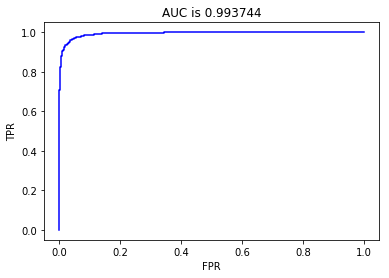

(        auc      aupr     accu      prec      recc       kap      mcc
 0  0.993744  0.978461  0.97266  0.959732  0.890411  0.907144  0.90809,
 array([[3483,   30],
        [  88,  715]]))

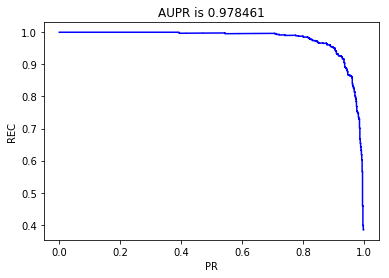

In [33]:
#Print out the performance for each of the model:
#Start from GRU:
cal_score(Y_test_e, test_pred_0e)

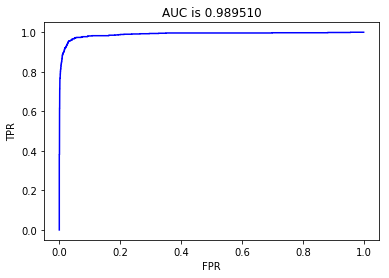

(       auc      aupr      accu     prec      recc      kap       mcc
 0  0.98951  0.972054  0.970343  0.94702  0.890411  0.89977  0.900406,
 array([[3473,   40],
        [  88,  715]]))

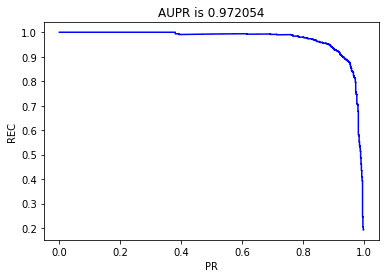

In [128]:
#Print out the performance for each of the model:
#######
#Prediction of the earn:
#LSTM one-direction:
#Evaluate the prediction for the earn(LSTM one direction):
cal_score(Y_test_e, test_pred_1e)

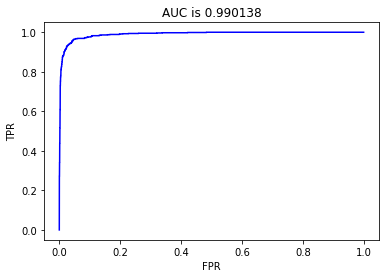

(        auc     aupr      accu      prec      recc       kap       mcc
 0  0.990138  0.96464  0.958063  0.847098  0.945205  0.867457  0.869476,
 array([[3376,  137],
        [  44,  759]]))

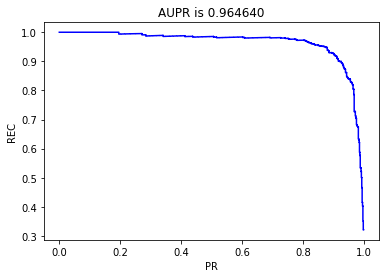

In [129]:
#Bi-directional LSTM:
cal_score(Y_test_e, test_pred_2e)

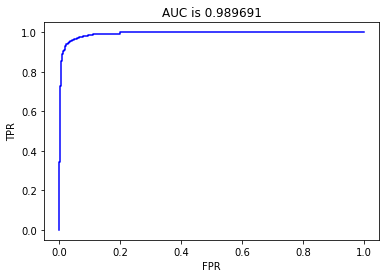

(        auc      aupr     accu      prec      recc       kap       mcc
 0  0.989691  0.967943  0.96988  0.921151  0.916563  0.900359  0.900364,
 array([[3450,   63],
        [  67,  736]]))

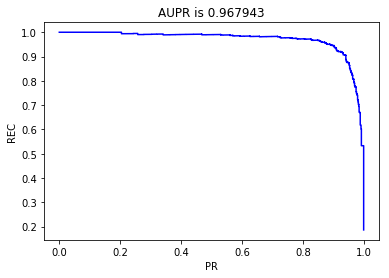

In [130]:
#LSTM-AE:
cal_score(Y_test_e, test_pred_3e)

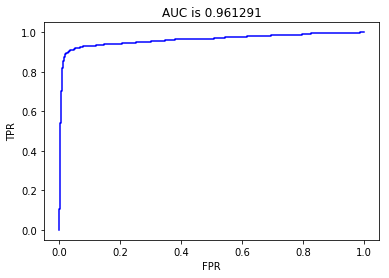

(        auc      aupr      accu      prec      recc       kap       mcc
 0  0.961291  0.918972  0.961538  0.928668  0.859278  0.869243  0.870215,
 array([[3460,   53],
        [ 113,  690]]))

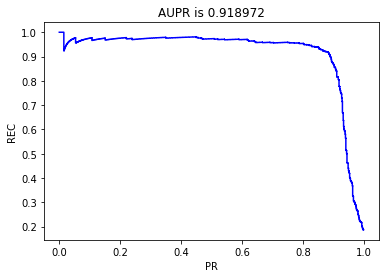

In [131]:
#LSTM-VAE:
cal_score(Y_test_e, test_pred_4e)

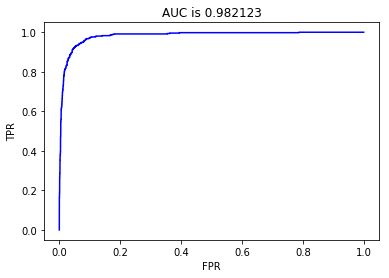

(        auc      aupr      accu      prec      recc       kap       mcc
 0  0.982123  0.885464  0.954124  0.896142  0.649462  0.728538  0.740022,
 array([[3816,   35],
        [ 163,  302]]))

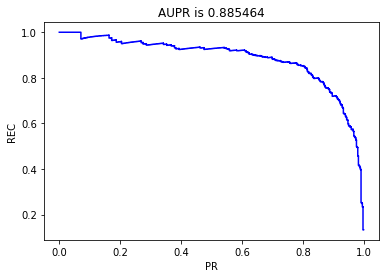

In [34]:
###
#The AUPR doesn't seem good.
cal_score(Y_test_a, test_pred_0a)

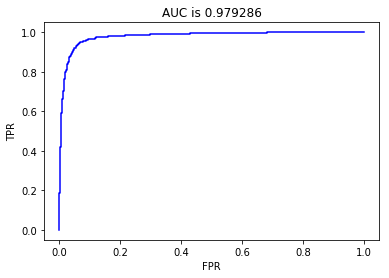

(        auc      aupr      accu     prec      recc       kap       mcc
 0  0.979286  0.870367  0.955746  0.87027  0.692473  0.747111  0.753093,
 array([[3803,   48],
        [ 143,  322]]))

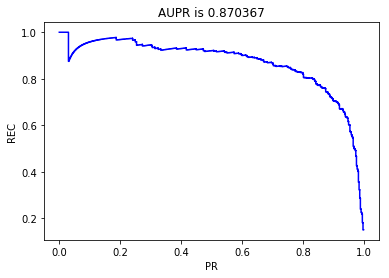

In [132]:
#For predicting the acq:
#LSTM one-direction
cal_score(Y_test_a, test_pred_1a)

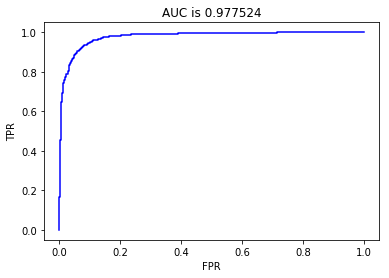

(        auc      aupr      accu      prec      recc       kap       mcc
 0  0.977524  0.871626  0.958526  0.835681  0.765591  0.776028  0.776954,
 array([[3781,   70],
        [ 109,  356]]))

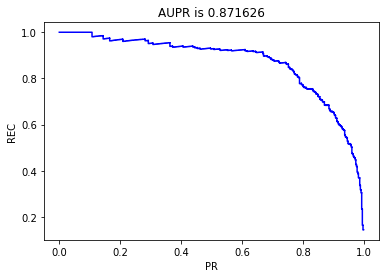

In [133]:
#Bi-directional LSTM:
cal_score(Y_test_a, test_pred_2a)

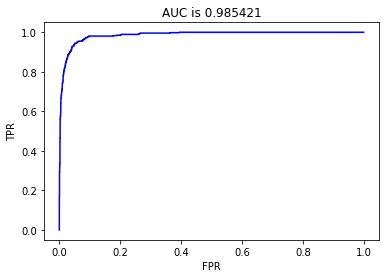

(        auc      aupr      accu      prec  recc       kap       mcc
 0  0.985421  0.906306  0.965014  0.865116   0.8  0.811802  0.812575,
 array([[3793,   58],
        [  93,  372]]))

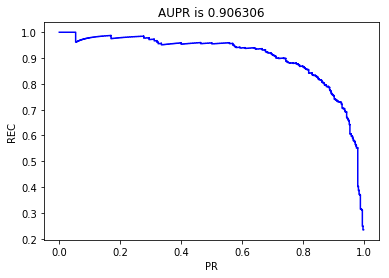

In [134]:
#LSTM-AE:
cal_score(Y_test_a, test_pred_3a)
#We observe that the LSTM-AE gets an improvement in both AUPR and AUROCs

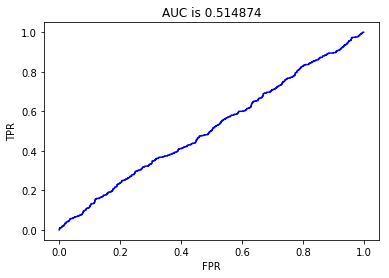

/Users/ruanhq/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ruanhq/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(        auc      aupr      accu  prec  recc  kap  mcc
 0  0.514874  0.120698  0.892261   0.0   0.0  0.0  0.0, array([[3851,    0],
        [ 465,    0]]))

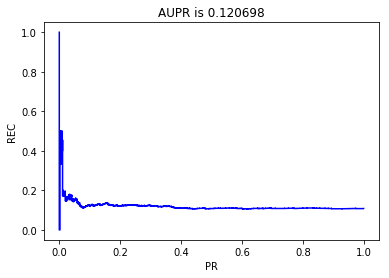

In [135]:
#LSTM-VAE:
cal_score(Y_test_a, test_pred_4a)

In [160]:
#Visualize the latent space:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap, TSNE


### 1.The high level intuition of the autoencoder is to do a kind of pre-training. As we attach a classifier at the latent space,  we further investigate the latent space in which we integrate more classifiers apart from MLP independently to further improve the classification performance.
### 2. VAE-LSTM may not be useful as the log($\sigma^{2} $) in the sampling procedure can be unlimited in which may introduce a lot of numerical instability. Another reason maybe the limited sample size.

In [98]:
#Incorporate xgboost and GBDT on top of the latent space:
X_train_el, X_test_el, Y_train_el, Y_test_el = train_test_split(latent_earn1, Y_earn, test_size = 0.2, random_state = 42)
X_train_al, X_test_al, Y_train_al, Y_test_al = train_test_split(latent_acq1, Y_acq, test_size = 0.2, random_state = 1)


In [116]:
#Apply the GBDT and XGBoost on the predicted features:
from sklearn.ensemble import GradientBoostingClassifier
#param_gb = {'max_depth': [3, 6, 8, 10],
#           'n_estimators': [100, 200, 300]}
#gbc_model = GradientBoostingClassifier()
#gbt = GridSearchCV(gbc_model, param_grid = param_gb, cv = 5, scoring = 'accuracy')
#gbt.fit(X_train_el, Y_train_el)
#gbd_e = gbt.best_estimator_

param_xgb = {
    'max_depth': [3, 6, 10],
    'eta': [0.5],
    'lambda':[0.5],
    'alpha': [0.1],
    'n_estimator': [200, 400, 600],
    'subsample': [0.2, 0.5, 0.8]
}

model = XGBClassifier()
xgb_model = GridSearchCV(model, param_grid = param_xgb, cv = 5, scoring = 'accuracy')
xgb_model.fit(X_train_el, Y_train_el)
xgb_best_e = xgb_model.best_estimator_


In [117]:
from sklearn.ensemble import GradientBoostingClassifier
param_gb = {'max_depth': [3, 6, 8, 10],
           'n_estimators': [100, 200, 300]}
gbc_model = GradientBoostingClassifier()
gbt = GridSearchCV(gbc_model, param_grid = param_gb, cv = 5, scoring = 'accuracy')
gbt.fit(X_train_al, Y_train_al)
gbd_a = gbt.best_estimator_

param_xgb = {
    'max_depth': [3, 6, 10],
    'eta': [0.5],
    'lambda':[0.5],
    'alpha': [0.1],
    'n_estimator': [200, 400, 600],
    'subsample': [0.2, 0.5, 0.8]
}

model = XGBClassifier()
xgb_model = GridSearchCV(model, param_grid = param_xgb, cv = 5, scoring = 'accuracy')
xgb_model.fit(X_train_al, Y_train_al)
xgb_best_a = xgb_model.best_estimator_

In [138]:
y_pred_el_gbdt = gbd_e.predict(X_test_el)
y_pred_el_xgbo = xgb_best_e.predict(X_test_el)

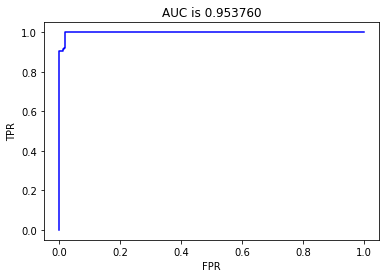

(       auc      aupr      accu      prec      recc       kap       mcc
 0  0.95376  0.879797  0.970806  0.927939  0.914072  0.903052  0.903091,
 array([[3456,   57],
        [  69,  734]]))

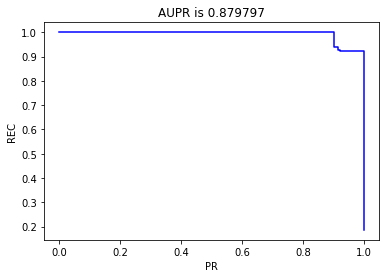

In [155]:
#Observe a increase in MCC, from 0.87 to 0.903
cal_score(Y_test_e, y_pred_el_gbdt * 0.6 + y_pred_el_xgbo * 0.4) #(y_pred_el_gbdt * 0.1 + y_pred_el_xgbo * 0.1 + test_pred_2e * 0.8))

In [124]:
y_pred_al_gbdt = gbd_a.predict(X_test_al)
y_pred_al_xgbo = xgb_best_a.predict(X_test_al)

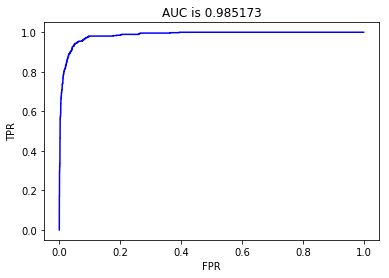

(        auc     aupr      accu      prec      recc       kap       mcc
 0  0.985173  0.90486  0.964551  0.859447  0.802151  0.810052  0.810652,
 array([[3790,   61],
        [  92,  373]]))

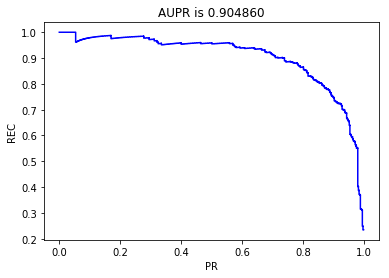

In [159]:
#Observe an increase in MCC by 0.04 from 0.77 to 0.81
cal_score(Y_test_a, (0.4 * y_pred_al_gbdt + 0.5 * y_pred_al_xgbo + 0.1 * test_pred_3a))

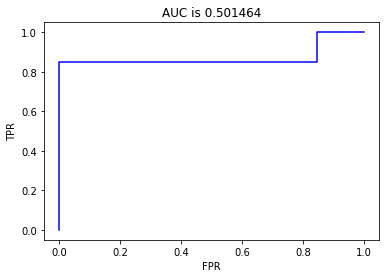

(        auc      aupr      accu      prec      recc       kap
 0  0.501464  0.108021  0.228452  0.108071  0.849462  0.000729,
 array([[ 591, 3260],
        [  70,  395]]))

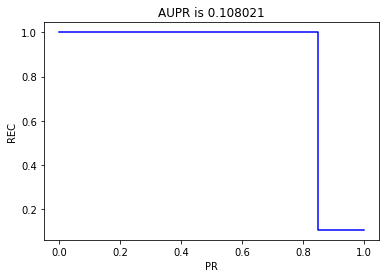

In [120]:
#Compare Complement Naive-Bayes Classifier for both response variables prediction:
nb_mod = ComplementNB()
nb_mod.fit(X_train_a, Y_train_a)
cnb_pred_a = nb_mod.predict(X_test_a)
cal_score(Y_test_a, cnb_pred_a)

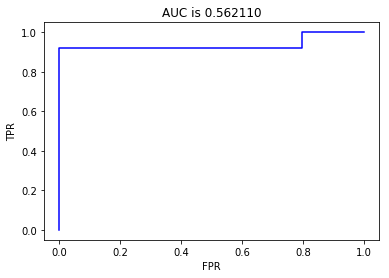

(       auc      aupr      accu      prec      recc       kap
 0  0.56211  0.207182  0.336423  0.208981  0.921544  0.053655,
 array([[ 712, 2801],
        [  63,  740]]))

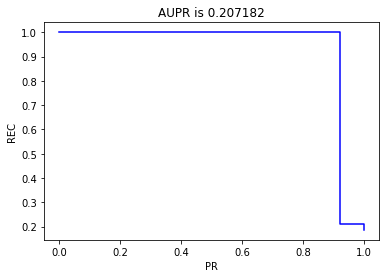

In [121]:
nb_mod = ComplementNB()
nb_mod.fit(X_train_e, Y_train_e)
cnb_pred_e = nb_mod.predict(X_test_e)
cal_score(Y_test_e, cnb_pred_e)

# You can see that Naive Bayes and Complement Naive Bayes does awful :)

# Discussion:
1. Jointly training LSTM classifier and a LSTM VAE may pretty hard to tune, sometimes doesn't work. (Reasons can come from numerical instability in sampling latent space - especially initialization)
2. LSTM based model perform slightly better than the model with GRU architecture.
3. LSTM-Autoencoder gets better performance in both prediction tasks(Better than the state-of-art results that provided in the official website of the data).
4. Bi-directional LSTM doesn't seem a significant improvement compared to the one-directional methodology.
5. Naive Bayes is pretty clumsy in this setting as the features may not be independent(there will be covariation structure among words).
6. GBDT and XGBoost on the latent space can help achieve improvement on the ordinary LSTM model but can't get improvement on the LSTM-Autoencoder. Model blending can help improve the performance.

Jointly training LSTM classifier and an autoencoder gets the best performance.

### We observe that for highly unbalanced acq data, the LSTM-AE method works pretty well with AUPR achieving 0.91.